In [40]:
from fastai.vision.all import *
from moving_mnist.models.phy_original import *
from moving_mnist.models.seq2seq import TeacherForcing
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [41]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())
    device = 0

Quadro RTX 8000


# Train PhyDNet:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [42]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [43]:
DATA_PATH = Path.cwd()/'data'

In [44]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=None)

In [45]:
train_tl = TfmdLists(range(12500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [46]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [47]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

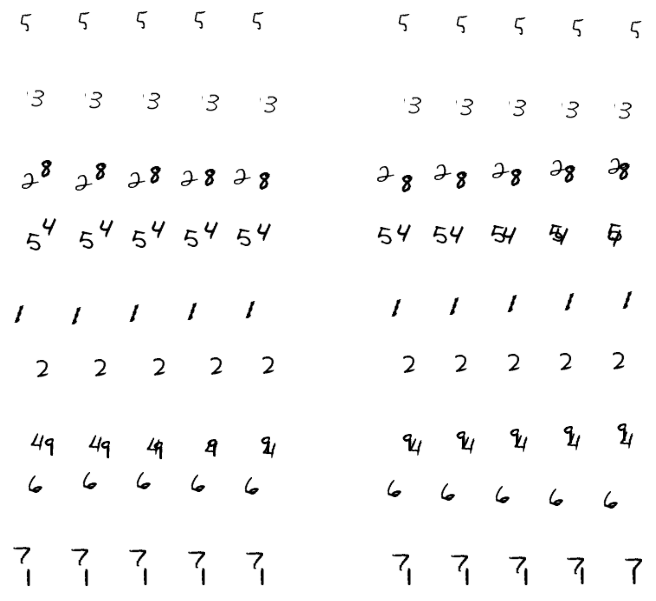

In [48]:
dls.show_batch()

In [49]:
b = dls.one_batch()

In [50]:
explode_types(b)

{tuple: [{moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

In [51]:
x,y = b 
x[0].shape

torch.Size([64, 1, 64, 64])

## PhyDNet

In [52]:
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convlstm =  ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder = EncoderRNN(phycell, convlstm, device)

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [53]:
model = StackUnstack(PhyDNet(encoder), dim=1).cuda()

In [54]:
model(x, y);

In [55]:
#export
class PHyCallback(Callback):
    def __init__(self, enc_loss_func=MSELossFlat()):
        store_attr()
    def after_pred(self):
        self.learn.pred, self.learn.loss_phy = self.pred
    def after_loss(self):
        self.learn.loss += self.learn.loss_phy

In [56]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, 
                cbs=[TeacherForcing(6), PHyCallback(mse_loss)])

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(12, 1e-3)

In [ ]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [ ]:
len(p), p[0].shape

In [ ]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

In [ ]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)